In [9]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

In [ ]:
def load_all_csvs(folder):
    files = glob.glob(os.path.join(folder, '*.xlsx'))
    df_list = []
    for file in files:
        try:
            df = pd.read_excel(file)
            df_list.append(df)
        except Exception as e:
            print(f"Error in {file}: {e}")
    return pd.concat(df_list)


def find_non_numeric_entries(df, column_name):
    df[column_name] = df[column_name].astype(str)
    non_numeric = df[~df[column_name].str.replace('.', '', regex=False).str.isnumeric()]
    unique_non_numeric = non_numeric[column_name].unique()
    return unique_non_numeric


def format_data(path_price, path_load):
    load_df = load_all_csvs(path_load)
    price_df = load_all_csvs(path_price)
    load_df['DateTime'] = pd.to_datetime(load_df['DateUTC'], utc=True)
    price_df['DateTime'] = pd.to_datetime(price_df['CreationDate'], utc=True)
    load_df.set_index('DateTime', inplace=True)
    price_df.set_index('DateTime', inplace=True)
    price_df_new=price_df.copy()
    load_df_new=load_df.copy()
    price_df=price_df_new.copy()
    load_df=load_df_new.copy()
    load_df.drop(columns=['MeasureItem', 'DateShort', 'TimeFrom', 'TimeTo', 'Cov_ratio', 'Value_ScaleTo100', 'UpdateDate'], inplace=True)
    price_df.drop(columns=['MeasureItem', 'Month', 'Year', 'Category', 'MeasureItemID', 'Representativity'], inplace=True)
    load_df.rename(columns={'Value': 'load'}, inplace=True)
    price_df.rename(columns={'ProvidedValue': 'price'}, inplace=True)
    price_df=price_df[price_df['price'].notnull()]
    price_df=price_df[price_df['CreationDate'].notnull()]
    load_df=load_df[load_df['load'].notnull()]
    load_df=load_df[load_df['CreateDate'].notnull()]
    load_df['Date'] = load_df.index.date
    price_df['Date'] = price_df.index.date
    non_numeric_entries = find_non_numeric_entries(price_df, 'price')
    price_df = price_df[~price_df['price'].isin(non_numeric_entries)]
    price_df['price'] = price_df['price'].astype(float)
    price_df['Date'] = pd.to_datetime(price_df['Date'])
    load_df['Date'] = pd.to_datetime(load_df['DateUTC'])
    load_df['Date'] = load_df['Date'].dt.date  
    price_grouped_df = price_df.groupby(['Date', 'Country'])['price'].mean().reset_index()
    price_grouped_df.rename(columns={'Country': 'CountryCode'}, inplace=True) 
    load_grouped_df = load_df.groupby(['Date', 'CountryCode'])['load'].mean().reset_index() 
    price_check = price_grouped_df['CountryCode'].value_counts().reset_index()
    price_check.columns = ['CountryCode', 'Count']
    load_check = load_grouped_df['CountryCode'].value_counts().reset_index()
    load_check.columns = ['CountryCode', 'Count']
    price_to_use_countries=price_check[price_check['Count']>=10]['CountryCode'].unique()
    load_to_use_countries=load_check[load_check['Count']>=10]['CountryCode'].unique()
    return price_grouped_df, price_to_use_countries, load_grouped_df, load_to_use_countries


def model_price(price_grouped_df, price_to_use_countries, country):
    df = price_grouped_df.copy()
    df['ds'] = pd.to_datetime(df['Date'])  
    df = df[['ds', 'price', 'CountryCode']].rename(columns={'price': 'y'})
    df['dayofweek'] = df['ds'].dt.dayofweek  
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['day'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.isocalendar().week

    results = {}
    for country in [country]:
        print(f"\n==== Forecasting for {country} ====")
        df_country = df[df['CountryCode'] == country].sort_values('ds')
        X = df_country[['dayofweek', 'month', 'year', 'day', 'weekofyear']]
        y = df_country['y']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
        param_grid = {
        'n_estimators': [100, 200,300, 400, 500],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'subsample': [0.7,0.8,0.9, 1.0],
        'colsample_bytree': [0.8,0.9, 1.0]
        }
        grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        print(f"Best parameters for {country}: {best_params}")
        model = XGBRegressor(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"{country} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
        plt.figure(figsize=(10, 6))
        plt.plot(df_country['ds'].iloc[-len(y_test):], y_test, label="Actual", color='blue')
        plt.plot(df_country['ds'].iloc[-len(y_test):], y_pred, label="Predicted", color='red', linestyle='--')
        plt.title(f"{country} - Actual vs Predicted Prices")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()
        last_date = df_country['ds'].max()
        future_dates = pd.date_range(start=last_date, periods=1826, freq='D')[1:]  
        future_df = pd.DataFrame({
        'ds': future_dates,
        'dayofweek': future_dates.dayofweek,
        'month': future_dates.month,
        'year': future_dates.year,
        'day': future_dates.day,
        'weekofyear': future_dates.isocalendar().week
        })
        future_X = future_df[['dayofweek', 'month', 'year', 'day', 'weekofyear']]
        future_predictions = model.predict(future_X)
        plt.figure(figsize=(10, 6))
        plt.plot(future_dates, future_predictions, label="Predicted Price", color='green', linestyle='--')
        plt.title(f"{country} - Predicted Price for the Next 5 Years")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()
        results[country] = {
        'model': model,
        'best_params': best_params,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'future_predictions': future_predictions,
        'future_dates': future_dates
        }
        return results


def model_load(load_grouped_df, load_to_use_countries, country):
    df = load_grouped_df.copy()
    df['ds'] = pd.to_datetime(df['Date']) 
    df = df[['ds', 'load', 'CountryCode']].rename(columns={'load': 'y'})
    df['dayofweek'] = df['ds'].dt.dayofweek 
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['day'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.isocalendar().week
  
    results = {}
    for country in [country]:
        print(f"\n==== Forecasting for {country} ====")
        df_country = df[df['CountryCode'] == country].sort_values('ds')
        X = df_country[['dayofweek', 'month', 'year', 'day', 'weekofyear']]
        y = df_country['y']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
        param_grid = {
        'n_estimators': [100, 200,300, 400, 500],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'subsample': [0.7,0.8,0.9, 1.0],
        'colsample_bytree': [0.8,0.9, 1.0]
        }
        grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        print(f"Best parameters for {country}: {best_params}")
        model = XGBRegressor(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"{country} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
        plt.figure(figsize=(10, 6))
        plt.plot(df_country['ds'].iloc[-len(y_test):], y_test, label="Actual", color='blue')
        plt.plot(df_country['ds'].iloc[-len(y_test):], y_pred, label="Predicted", color='red', linestyle='--')
        plt.title(f"{country} - Actual vs Predicted Load")
        plt.xlabel("Date")
        plt.ylabel("Load")
        plt.legend()
        plt.show()
        last_date = df_country['ds'].max()
        future_dates = pd.date_range(start=last_date, periods=1826, freq='D')[1:]  
        future_df = pd.DataFrame({
        'ds': future_dates,
        'dayofweek': future_dates.dayofweek,
        'month': future_dates.month,
        'year': future_dates.year,
        'day': future_dates.day,
        'weekofyear': future_dates.isocalendar().week
        })
        future_X = future_df[['dayofweek', 'month', 'year', 'day', 'weekofyear']]
        future_predictions = model.predict(future_X)
        plt.figure(figsize=(10, 6))
        plt.plot(future_dates, future_predictions, label="Predicted Load", color='green', linestyle='--')
        plt.title(f"{country} - Predicted Load for the Next 5 Years")
        plt.xlabel("Date")
        plt.ylabel("Load")
        plt.legend()
        plt.show()
        results[country] = {
        'model': model,
        'best_params': best_params,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'future_predictions': future_predictions,
        'future_dates': future_dates
        }
        return results

c:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\envs\python_updated\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\envs\python_updated\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\envs\python_updated\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\envs\python_updated\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's

Unique non-numeric entries in 'price' column:

==== Forecasting for FR ====
Fitting 3 folds for each of 900 candidates, totalling 2700 fits


c:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\envs\python_updated\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for FR: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
FR - MSE: 71877.48554401995, RMSE: 268.09976789251414, MAE: 227.03194934548966


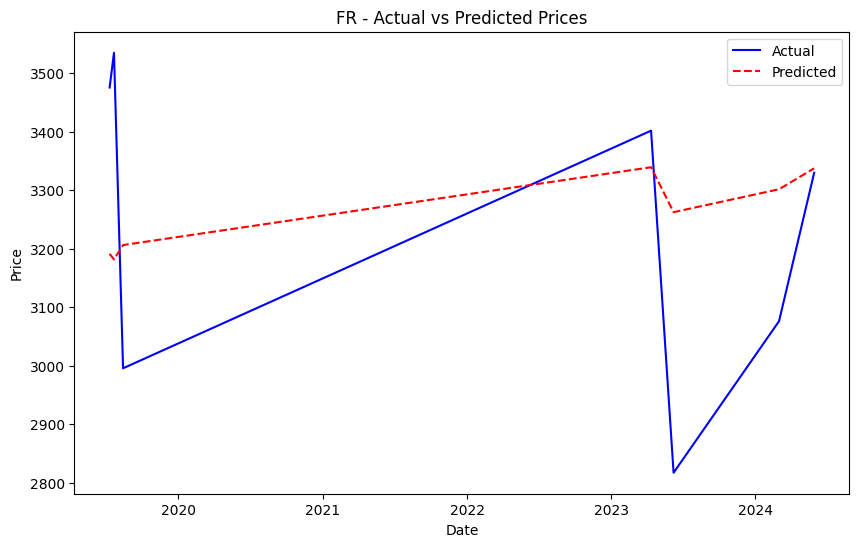

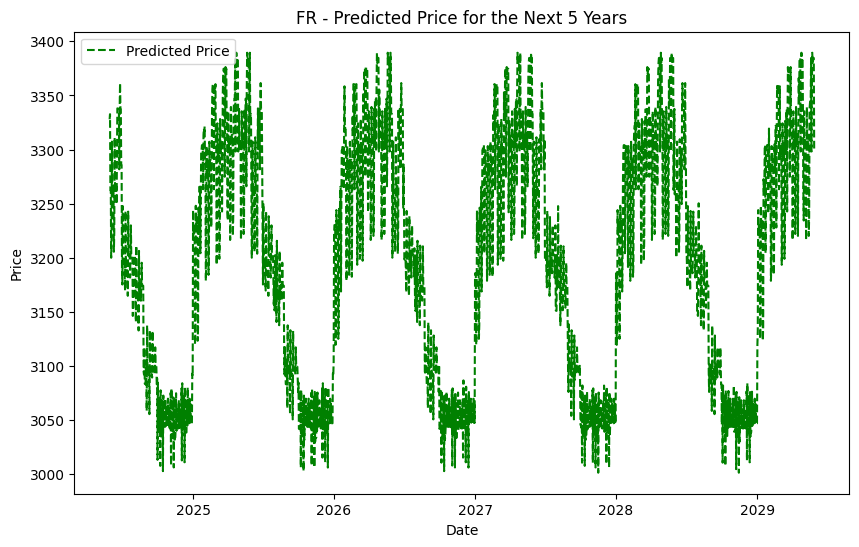


==== Forecasting for FR ====
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
Best parameters for FR: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
FR - MSE: 17916210.010772523, RMSE: 4232.754423631558, MAE: 3109.0099143834996


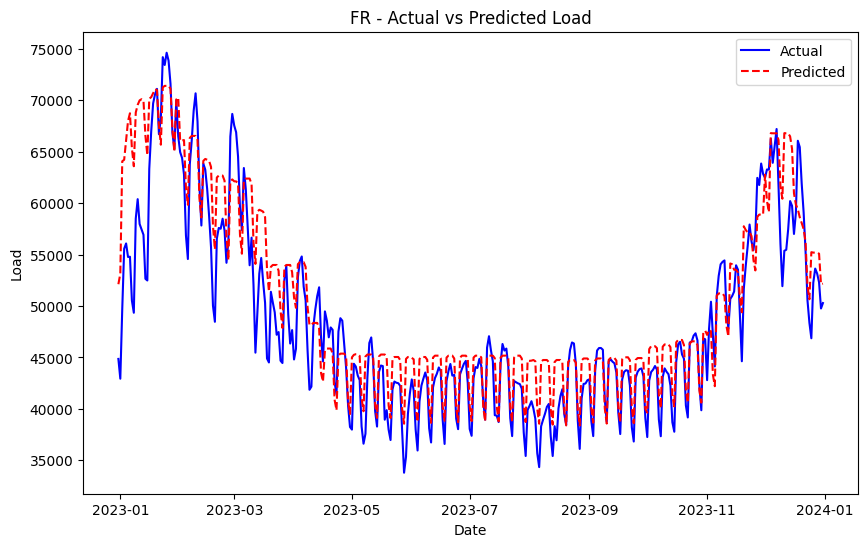

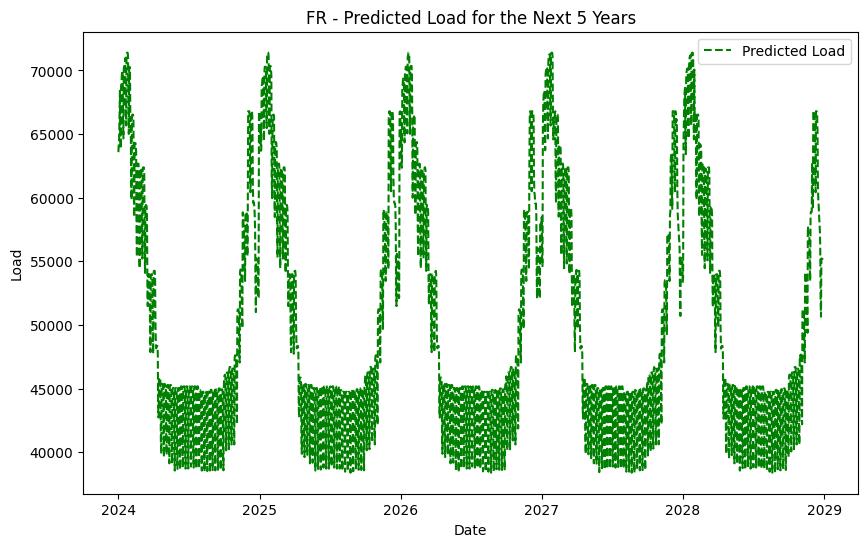

In [12]:
path_load = r'C:\Users\a-spyrosploussiou\Downloads\hourly_load_edf'
path_price = r'C:\Users\a-spyrosploussiou\Downloads\monthly_domestic_edf'
country = 'FR'

price_grouped_df, price_to_use_countries, load_grouped_df, load_to_use_countries = format_data(path_price, path_load)
model_results_price = model_price(price_grouped_df, price_to_use_countries, country)
model_results_load = model_load(load_grouped_df, load_to_use_countries, country)